# Cumulated WaterPoint

This script provides the figure for cumulated water point. (note that you need to build the event "Water Stop" to get this graph)

*Warning: we set the waterpoint at the bottom right of the cage. If you use another location, change the code of the rebuildWaterPoint.py file.*

| ![](../images/cumulatedwaterpoint1.jpg) ![](../images/cumulatedwaterpoint2.jpg) ![](../images/cumulatedwaterpoint3.jpg) ![](../images/cumulatedwaterpoint4.jpg)
|:--:| 
|Example of cumulated water point|

Code launched.


Start :  55555


Entry (in frame) : 55555


End :  4555555


Entry (in frame) : 4555555
D:/Stage_M2/LMT+Amphet/221024_Amphet_Cage2_5-3Amphet.sqlite
Cage2_5-3Amphet
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849390 Genotype:Amphet User1:None
Animal Id:2 Name:B RFID:000004849551 Genotype:Amphet User1:None
Animal Id:3 Name:C RFID:000004849540 Genotype:Amphet User1:None
000004849390
Water Stop  Id( 1 , None , None , None ) Min/maxFrame: ( 55555 / 4555555 ) Loaded ( 5  records loaded in  4.121130704879761 S )
000004849551
Water Stop  Id( 2 , None , None , None ) Min/maxFrame: ( 55555 / 4555555 ) Loaded ( 23  records loaded in  0.5356695652008057 S )
000004849540
Water Stop  Id( 3 , None , None , None ) Min/maxFrame: ( 55555 / 4555555 ) Loaded ( 1  records loaded in  0.5397183895111084 S )
loading night events for file D:/Stage_M2/LMT+Amphet/221024_Amphet_Cage2_5-3Amphet.sqlite
night  Id( None , None , None , N

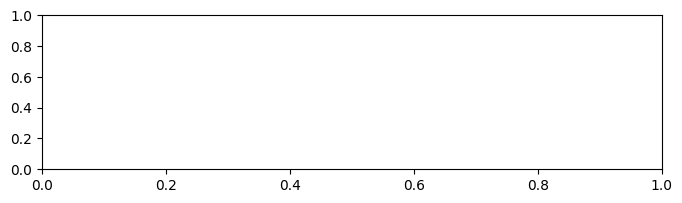

In [1]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *

import lmtanalysis
from tkinter.filedialog import askopenfilename
from tabulate import tabulate
from collections import Counter
import collections
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from lmtanalysis.FileUtil import getFilesToProcess
from lmtanalysis.Util import convert_to_d_h_m_s, getMinTMaxTInput,getFrameInput


def frameToTimeTicker(x, pos):
   
    vals= convert_to_d_h_m_s( x )
    return "D{0} - {1:02d}:{2:02d}".format( int(vals[0])+1, int(vals[1]), int(vals[2]) )
    
if __name__ == '__main__':
    
    print("Code launched.")
    saveFile = "figTimeLineActivity"
    #Choose the files to process
    files = getFilesToProcess()
    tmin = getFrameInput("Start")
    tmax = getFrameInput("End")

    for file in files:
        print(file)
        expName = file[-22:-7]
        print( expName )
        
        connection = sqlite3.connect( file )
    
        pool = AnimalPool( )
        pool.loadAnimals( connection )
        """        
        pool.loadDetection( start = tmin, end = tmax, lightLoad=True)
        """
        #Load the timeline of the water stop event over all individuals
        waterStopTimeLine = {}
        for animal in pool.animalDictionnary.keys():
            print ( pool.animalDictionnary[animal].RFID )
            waterStopTimeLine[animal] = EventTimeLine( connection, "Water Stop", idA=animal, minFrame=tmin, maxFrame=tmax )
            waterStopTimeLine[animal].removeEventsBelowLength( maxLen = MIN_WATER_STOP_DURATION )
        
        
        #Compute cumulative time spent at water point
        fig, ax = plt.subplots( 1,1 , figsize=(8, 2 ) )
        
        ''' build the plot '''
        
        ymin=-30
        fig, ax = plt.subplots( 1,1 , figsize=(8, 2 ) )
        ax = plt.gca() # get current axis
        ax.set_xlabel("time")
        ax.set_xlim([0, tmax])
        #ax.set_ylim([ymin, ymax])
        
        #set x axis
        formatter = matplotlib.ticker.FuncFormatter( frameToTimeTicker )
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(labelsize=6 )
        ax.xaxis.set_major_locator(ticker.MultipleLocator( 30 * 60 * 60 * 12 ))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator( 30 * 60 * 60 ))
        
        #draw the rectangles for the nights
        print("loading night events for file " + file)
        nightTimeLine = EventTimeLine( connection, "night" , minFrame=tmin, maxFrame=tmax )
        
        for nightEvent in nightTimeLine.getEventList():
            ax.axvspan( nightEvent.startFrame, nightEvent.endFrame, alpha=0.1, color='black')
            ax.text( nightEvent.startFrame+(nightEvent.endFrame-nightEvent.startFrame)/2 , 200 , "dark phase" ,fontsize=6, ha='center')
        
        waterPointDuration = {}
        timeBin = 1
        
        #Print the name and genotype of the animals on the graph, with the corresponding colors and the total distance traveled over the experiment
        legendHeight = 60
        for animal in pool.animalDictionnary.keys():
            print ( pool.animalDictionnary[animal].RFID )
            ax.text(30*60*60, legendHeight, "{} {}".format(pool.animalDictionnary[animal].RFID[5:], pool.animalDictionnary[animal].genotype), color=getAnimalColor(animal), fontsize=5 )
            legendHeight += 30 
        
        
        for animal in pool.animalDictionnary.keys():
            listCumulated = []
            listValue = waterStopTimeLine[animal].getDurationEventInTimeBin( tmin=tmin, tmax=tmax, binSize=timeBin*oneMinute)
            cumul = 0
            for value in listValue:
                cumul+= value
                listCumulated.append( cumul )
            waterPointDuration[animal ]= listCumulated
        
        nTimeBins = len(waterPointDuration[1])
        print(nTimeBins)
        
        abs = [1*oneMinute]
        for t in range(1, nTimeBins):
            x = abs[t-1] + timeBin*oneMinute
            abs.append(x)
            
        for animal in waterPointDuration:    
            ax.plot( abs, waterPointDuration[animal] , color= getAnimalColor( animal ))
        
        
        figName = "FigCumulWaterPoint_{}.pdf".format( expName )
        print ("Saving figure..." , figName )
        
        fig.savefig( figName ,dpi=100)
        plt.close( fig )    
